In [1]:
import optuna
import torch
from kernels import get_mean_covar
from likelihoods import MultitaskBetaLikelihood
from models import MultitaskGPModel
from data import PVWeatherGenerator, SystemLoader

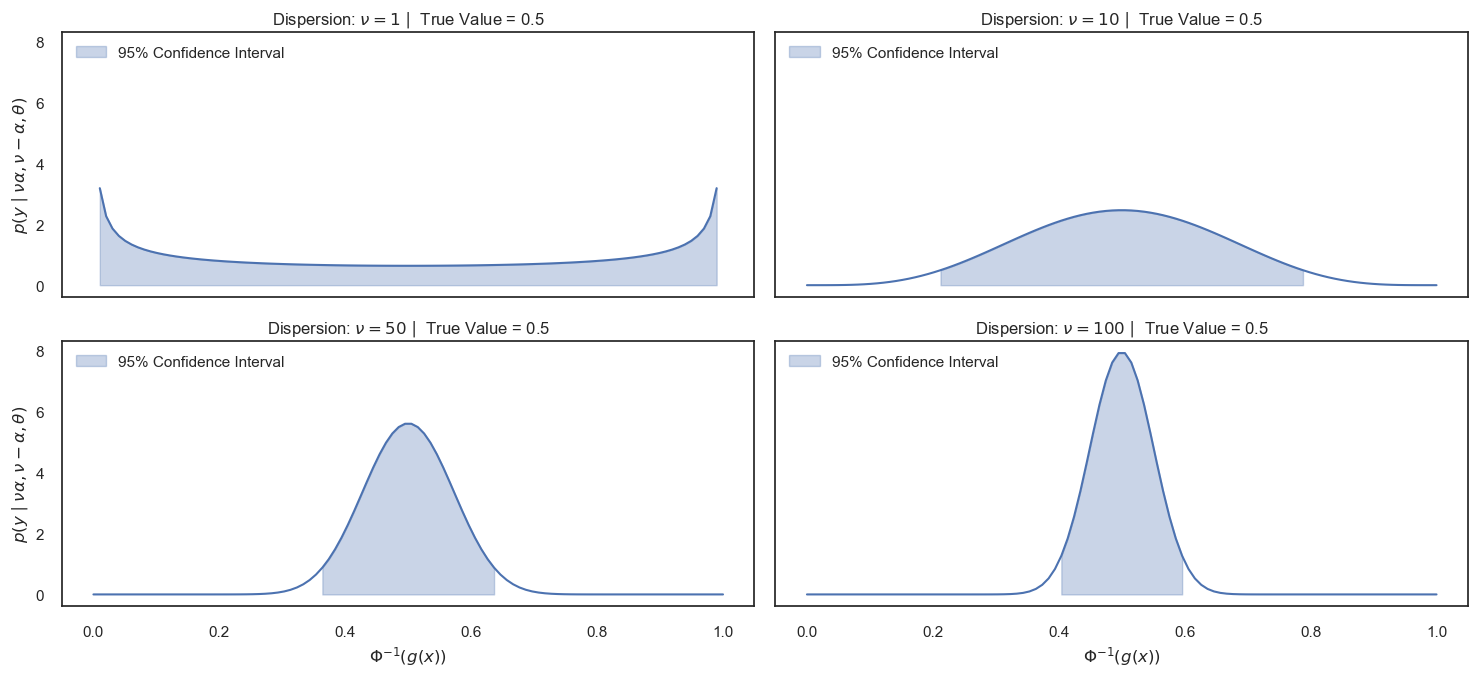

In [103]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

x = torch.linspace(0, 1, 100)
dispersion = [1, 10, 50, 100]

# Confidence level (e.g., 95%)
confidence_level = 0.95

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2, figsize=(15, 7), sharex=True, sharey=True)
ax = ax.flatten()

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'font.family': 'Arial'})

for i, v in enumerate(dispersion):
    alpha = torch.tensor(v) * 0.5
    beta = torch.tensor(v) - alpha
    alpha = torch.clamp(alpha, min=1e-3)
    beta = torch.clamp(beta, min=1e-3)
    dist = torch.distributions.beta.Beta(alpha, beta)
    pred_likelihood = dist.log_prob(x).exp()

    ax[i].plot(x, pred_likelihood)
    ax[i].set_title(r"Dispersion: $\nu={} \mid$".format(v) + ' True Value = 0.5')

    # Calculate the 95% confidence interval
    lower_bound = stats.beta.ppf((1 - confidence_level) / 2, alpha, beta)
    upper_bound = stats.beta.ppf(1 - (1 - confidence_level) / 2, alpha, beta)

    ax[i].fill_between(x, 0, pred_likelihood, where=(x >= lower_bound) & (x <= upper_bound), color='b', alpha=0.3,
                       label='95% Confidence Interval')

    # set ylabels only for the left column
    if i % 2 == 0:
        ax[i].set_ylabel(r"$p(y \mid \nu  \alpha , \nu - \alpha,  \theta)$")

    # set xlabels only for the bottom row
    if i >= 2:
        ax[i].set_xlabel(r"$\Phi^{-1}(g(x))$")
    ax[i].legend(loc='upper left')

plt.tight_layout()
plt.show()


In [23]:
DAY_INIT = 0 # start of data is 01-01-2018
N_DAYS = 365 # data until 01-01-2019
DAY_MIN = 8 # starting hour of all our data (per day)
DAY_MAX = 16 # ending hour of all our data (per day)
MINUTE_INTERVAL = 5 # the minute interval of our data
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 // MINUTE_INTERVAL
N_DAYS_FOLD = 7
N_SYSTEMS = 6
CIRCLE_COORDS = (53.28, -3.05)
RADIUS = 0.25

In [24]:
generator = PVWeatherGenerator(
        coords=CIRCLE_COORDS,
        radius=RADIUS,
        day_init=DAY_INIT,
        n_systems=N_SYSTEMS,
        n_days=N_DAYS,
        minute_interval=MINUTE_INTERVAL,
    )
df = generator.df
num_tasks = N_SYSTEMS

train_interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD) # number of data points per system in each fold
# create loader that will iterate over the data
loader = SystemLoader(df, train_interval=train_interval, n_hours_pred=2)


==> Loading data
==> Loaded data in: 0 m : 23 sec



In [82]:
import optuna 
import torch
from gpytorch.metrics import negative_log_predictive_density as NLPD
from metrics import mean_absolute_error as MAE
# get not PSD error from gpytorch
from gpytorch.utils.errors import NotPSDError

def objective(trial, loader):
    scale = trial.suggest_int("scale", 1, 100, step=5)
    num_latents = trial.suggest_int("num_latents", 2, 5, step=1)
    likelihood = MultitaskBetaLikelihood(num_tasks=num_tasks, scale=scale)
    mean, covar = get_mean_covar(num_latent=num_latents)
    
    nlpds = []
    mean_abs_errors = []

    train_interval = int(DAILY_DATA_POINTS * N_DAYS_FOLD) # number of data points per system in each fold
    # create loader that will iterate over the data
    loader = SystemLoader(df, train_interval=train_interval, n_hours_pred=2)

    for k, (X_tr, Y_tr, X_te, Y_te, T_tr, T_te) in enumerate(loader):
        y_train = torch.stack([Y_tr[T_tr == i] for i in range(num_tasks)], dim=-1)
        y_test = torch.stack([Y_te[T_te == i] for i in range(num_tasks)], dim=-1)
        x = torch.linspace(0, 100, len(y_train) + len(y_test))
        x_train, x_test = x[:len(y_train)], x[len(y_train):]
        # define model
        model = MultitaskGPModel(
            X=x_train,
            y=y_train,
            likelihood=likelihood,
            mean_module=mean,
            covar_module=covar,
            num_latents=num_latents,
            jitter=1e-3)
        try:
            model.fit(n_iter=200, lr=0.1)
            pred_dist = model.predict(x_test)
            median, _, _ = model.predict(x_test, pred_type="median")
            nll = NLPD(pred_dist, y_test)
            nll[torch.isinf(nll)] = 1
            mae = MAE(median, y_test)
            print(f"Trial {k+1} NLPD: {nll.mean().item()}, MAE: {mae.mean().item()}")

            nlpds.append(nll.median().item())
            mean_abs_errors.append(mae.median().item())
        except NotPSDError:
            nlpds.append(1)
            mean_abs_errors.append(1)

        if k == 5:
            break
    
    mean_mae = sum(mean_abs_errors) / len(mean_abs_errors)
    mean_nlpd = sum(nlpds) / len(nlpds)

    
    return mean_mae + mean_nlpd

study = optuna.create_study(direction="minimize")
study.optimize(lambda trial: objective(trial, loader), n_trials=50)
    

[I 2023-09-14 21:08:58,722] A new study created in memory with name: no-name-14336010-a2f0-4cc5-b262-64d7d8da9b79


Trial 1 NLPD: 10.08001510132289, MAE: 0.3493049660704206
Trial 2 NLPD: 0.7448075084899403, MAE: 0.03929060944474641
Trial 3 NLPD: 4.66317231065829, MAE: 0.1142908286548838
Trial 4 NLPD: 2.3057198518027406, MAE: 0.10861882609139217
Trial 5 NLPD: 0.7201985168250533, MAE: 0.1224009099516478


[I 2023-09-14 21:25:12,332] Trial 0 finished with value: 2.4014597556910013 and parameters: {'scale': 91, 'num_latents': 5}. Best is trial 0 with value: 2.4014597556910013.


Trial 6 NLPD: 0.803867292291905, MAE: 0.09627458106202268
Trial 1 NLPD: 0.33328514363922485, MAE: 0.07818400564654707
Trial 2 NLPD: 0.22582285984575878, MAE: 0.08447911438447525
Trial 3 NLPD: 1.4116298134149559, MAE: 0.17605282388910007
Trial 4 NLPD: -0.11325282321263903, MAE: 0.09634226466430756
Trial 5 NLPD: 0.034535253404943296, MAE: 0.12681952669985191


[I 2023-09-14 21:35:17,388] Trial 1 finished with value: 0.22261390889881674 and parameters: {'scale': 21, 'num_latents': 3}. Best is trial 1 with value: 0.22261390889881674.


Trial 6 NLPD: 0.15572157875407808, MAE: 0.1508681442618104
Trial 1 NLPD: -0.0023678305737992403, MAE: 0.183941866419475
Trial 2 NLPD: -0.25497792785034656, MAE: 0.06624719365636332
Trial 3 NLPD: 0.8847917802511408, MAE: 0.22286383227520704
Trial 4 NLPD: -0.10664642762031194, MAE: 0.12357940836190423
Trial 5 NLPD: -0.010854427637876097, MAE: 0.15953792306478842


[I 2023-09-14 21:52:32,404] Trial 2 finished with value: 0.16158820016950842 and parameters: {'scale': 6, 'num_latents': 4}. Best is trial 2 with value: 0.16158820016950842.


Trial 6 NLPD: -0.14378452041963516, MAE: 0.07934251797671994
Trial 1 NLPD: 5.73444482125483, MAE: 0.3137747754401221
Trial 2 NLPD: 0.3811392973499734, MAE: 0.11399913796879603
Trial 3 NLPD: 1.7246455542377925, MAE: 0.1813324409360026
Trial 4 NLPD: 2.6422207511430225, MAE: 0.259837504382159
Trial 5 NLPD: 2.1630407833143375, MAE: 0.17954474147525204


[I 2023-09-14 22:00:07,438] Trial 3 finished with value: 1.8444282109170642 and parameters: {'scale': 61, 'num_latents': 2}. Best is trial 2 with value: 0.16158820016950842.


Trial 6 NLPD: 1.961131191396592, MAE: 0.17904952782990327
Trial 1 NLPD: 0.21455683777655887, MAE: 0.06391912642402474
Trial 2 NLPD: 0.2959281229567202, MAE: 0.08544799664303
Trial 3 NLPD: 3.455124648385955, MAE: 0.20361367419330126


[I 2023-09-14 22:04:59,698] Trial 4 finished with value: 1.427904353433404 and parameters: {'scale': 51, 'num_latents': 2}. Best is trial 2 with value: 0.16158820016950842.


Trial 6 NLPD: 2.4361165176913446, MAE: 0.20728967331418513
Trial 1 NLPD: 0.5267339259899296, MAE: 0.11044964724241324
Trial 2 NLPD: 3.1265139730685103, MAE: 0.1212577965652826
Trial 3 NLPD: 6.715521932725039, MAE: 0.19301030909666356
Trial 4 NLPD: 0.2418493105840432, MAE: 0.09032151948657617
Trial 5 NLPD: 0.752947420225014, MAE: 0.174242691064426


[I 2023-09-14 22:12:12,648] Trial 5 finished with value: 0.6845402078598729 and parameters: {'scale': 66, 'num_latents': 2}. Best is trial 2 with value: 0.16158820016950842.


Trial 6 NLPD: 1.423188264654481, MAE: 0.16623229351513819
Trial 1 NLPD: 7.449003181345205, MAE: 0.3493049660704206
Trial 2 NLPD: 2.1091272365839124, MAE: 0.02826680994810706
Trial 3 NLPD: 0.6688090351157501, MAE: 0.08485642904952925
Trial 4 NLPD: 1.3882893972241934, MAE: 0.12515050946603073
Trial 5 NLPD: 0.3088786670128267, MAE: 0.10865451735725076


[I 2023-09-14 22:27:18,989] Trial 6 finished with value: 2.273426182627754 and parameters: {'scale': 56, 'num_latents': 5}. Best is trial 2 with value: 0.16158820016950842.


Trial 6 NLPD: 1.7004479241037476, MAE: 0.18127023272332762
Trial 1 NLPD: 2.805260014075082, MAE: 0.03240258112340095
Trial 2 NLPD: 2.971354243745066, MAE: 0.00959844868640029
Trial 3 NLPD: -0.01705198270523128, MAE: 0.06352028253603671
Trial 4 NLPD: 0.3082843069542328, MAE: 0.11425575234359468
Trial 5 NLPD: 0.9906945478348508, MAE: 0.17577121988339048


[I 2023-09-14 22:41:29,398] Trial 7 finished with value: 1.1562322374855782 and parameters: {'scale': 56, 'num_latents': 5}. Best is trial 2 with value: 0.16158820016950842.


Trial 6 NLPD: 0.6551208081879756, MAE: 0.1765054990365971


[I 2023-09-14 22:42:09,354] Trial 8 finished with value: 2.0 and parameters: {'scale': 46, 'num_latents': 5}. Best is trial 2 with value: 0.16158820016950842.


Trial 1 NLPD: 0.14889540914668836, MAE: 0.18722821054521224
Trial 2 NLPD: -0.09796354429420821, MAE: 0.11185159376967091
Trial 5 NLPD: -0.0923071278390413, MAE: 0.11933800641436819


[I 2023-09-14 22:47:01,663] Trial 9 finished with value: 0.6715852504699227 and parameters: {'scale': 16, 'num_latents': 2}. Best is trial 2 with value: 0.16158820016950842.


Trial 6 NLPD: -0.10631212216743306, MAE: 0.10532213354881181
Trial 1 NLPD: -0.20914833273088868, MAE: 0.08075550871728437
Trial 2 NLPD: -0.03064628681007071, MAE: 0.08296417080798352
Trial 3 NLPD: 0.0483486237497741, MAE: 0.09897814807990271
Trial 4 NLPD: -0.1689930142184837, MAE: 0.08773786257748199
Trial 5 NLPD: 0.05463814648902481, MAE: 0.15714159543845493


[I 2023-09-14 22:58:42,820] Trial 10 finished with value: -0.11463387722122001 and parameters: {'scale': 1, 'num_latents': 4}. Best is trial 10 with value: -0.11463387722122001.


Trial 6 NLPD: -0.05608330576843988, MAE: 0.12165216859098248
Trial 1 NLPD: -0.20211829485292251, MAE: 0.08672347711078536
Trial 2 NLPD: -0.1765291516152805, MAE: 0.11454207068735395
Trial 3 NLPD: -0.3402084986821727, MAE: 0.0799932719637136
Trial 4 NLPD: -0.17510705366599777, MAE: 0.07635430237014833
Trial 5 NLPD: -0.10352643284025978, MAE: 0.11966706292807351


[I 2023-09-14 23:10:37,894] Trial 11 finished with value: -0.13216674634195907 and parameters: {'scale': 1, 'num_latents': 4}. Best is trial 11 with value: -0.13216674634195907.


Trial 6 NLPD: -0.013396271003970742, MAE: 0.12881665816141213
Trial 1 NLPD: -0.15727031489865895, MAE: 0.08971597506250231
Trial 2 NLPD: -0.026641476712193506, MAE: 0.0861972594281975
Trial 3 NLPD: -0.31610916504178055, MAE: 0.08892028305647617
Trial 4 NLPD: -0.16556683973205574, MAE: 0.08830957830238957
Trial 5 NLPD: 0.03286001381135304, MAE: 0.14958910106590326


[I 2023-09-14 23:19:54,440] Trial 12 finished with value: -0.15748810890585002 and parameters: {'scale': 1, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.17281451662832312, MAE: 0.08055855998235437
Trial 1 NLPD: 2.744722854300705, MAE: 0.23526095753376675
Trial 2 NLPD: 0.3663336811442421, MAE: 0.07509901530789029
Trial 3 NLPD: 1.1009658052618039, MAE: 0.11981413242547884
Trial 4 NLPD: 1.8533449192683296, MAE: 0.19784317503250187
Trial 5 NLPD: 0.34985040031166453, MAE: 0.1675391849878357


[I 2023-09-14 23:31:32,473] Trial 13 finished with value: 0.8402484812597617 and parameters: {'scale': 31, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.007857426100761757, MAE: 0.1028889257483414
Trial 1 NLPD: 0.8853661633232509, MAE: 0.08772991731034867
Trial 2 NLPD: 0.34799144845427776, MAE: 0.08363194261193399
Trial 3 NLPD: 0.9824885858448763, MAE: 0.18364453418418433
Trial 4 NLPD: 0.19786378459608567, MAE: 0.15861359186893756
Trial 5 NLPD: 0.49530332626243173, MAE: 0.17486242495433174


[I 2023-09-14 23:40:52,948] Trial 14 finished with value: 0.30310386696030994 and parameters: {'scale': 26, 'num_latents': 3}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.07353974699886488, MAE: 0.1518515401815706
Trial 1 NLPD: 0.00030162249721484474, MAE: 0.18914786173960815
Trial 2 NLPD: -0.25936559599834197, MAE: 0.08948350597370078
Trial 3 NLPD: -0.24752136458727536, MAE: 0.07469246347999181
Trial 4 NLPD: -0.10739255626174979, MAE: 0.08804216172779147
Trial 5 NLPD: 0.056007338320990835, MAE: 0.15408329348092378


[I 2023-09-14 23:56:31,351] Trial 15 finished with value: -0.10302790117071446 and parameters: {'scale': 1, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.13862398787871097, MAE: 0.09680662980942854
Trial 1 NLPD: 0.10683274057619449, MAE: 0.218035963090342
Trial 2 NLPD: -0.12849825590654337, MAE: 0.11029318735972955
Trial 3 NLPD: -0.24752754443619276, MAE: 0.0964542201023666
Trial 4 NLPD: 0.16099943361276967, MAE: 0.16341640859918993
Trial 5 NLPD: -0.10731906686449211, MAE: 0.12309065925972498


[I 2023-09-15 00:15:26,867] Trial 16 finished with value: 0.011737722672931383 and parameters: {'scale': 11, 'num_latents': 3}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.026404799690013487, MAE: 0.12491552933160281
Trial 2 NLPD: 0.48595614648458896, MAE: 0.07831027369625942
Trial 3 NLPD: 0.7576916398955171, MAE: 0.15522010981727677
Trial 4 NLPD: 0.19515943750777712, MAE: 0.118897512897597
Trial 5 NLPD: 0.1457897474255094, MAE: 0.1326045124034697


[I 2023-09-15 00:33:17,763] Trial 17 finished with value: 0.4562812368483037 and parameters: {'scale': 36, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.32154858799677605, MAE: 0.13888054770835004
Trial 1 NLPD: 2.8000720950283573, MAE: 0.03787179338854716
Trial 2 NLPD: 3.352518339927158, MAE: 0.1415644455485421
Trial 3 NLPD: 2.54195236562882, MAE: 0.1092357162491639
Trial 4 NLPD: 0.9834844154433809, MAE: 0.09573315623364292
Trial 5 NLPD: 2.85431761348943, MAE: 0.17214706094925536


[I 2023-09-15 00:50:59,521] Trial 18 finished with value: 1.4999396217926775 and parameters: {'scale': 76, 'num_latents': 3}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.23199713908354724, MAE: 0.08820360656668176
Trial 1 NLPD: 3.8150929349088445, MAE: 0.269032108021395
Trial 2 NLPD: -0.011322759158896955, MAE: 0.07073364272124603
Trial 3 NLPD: 0.9998421904583891, MAE: 0.12718924774975238
Trial 4 NLPD: 0.2766894856274172, MAE: 0.12735513185658107
Trial 5 NLPD: 0.928321965444578, MAE: 0.2053169121358168


[I 2023-09-15 01:10:40,066] Trial 19 finished with value: 1.1168455676031463 and parameters: {'scale': 41, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 1.8521765620509327, MAE: 0.228493878031186
Trial 1 NLPD: 0.14533399763939836, MAE: 0.19045861179508095
Trial 2 NLPD: -0.10524285574623479, MAE: 0.10805773178064361
Trial 3 NLPD: 0.7037712329815461, MAE: 0.12826922589574608
Trial 4 NLPD: 0.03270729680101126, MAE: 0.10531979634043573
Trial 5 NLPD: 0.032846081504564466, MAE: 0.13381712969715498


[I 2023-09-15 01:26:44,851] Trial 20 finished with value: 0.2136592512972989 and parameters: {'scale': 16, 'num_latents': 3}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.20773442909760864, MAE: 0.1557020079480523
Trial 1 NLPD: -0.14429155471995553, MAE: 0.10918423078615161
Trial 2 NLPD: -0.14234965640150218, MAE: 0.11156299580992836
Trial 3 NLPD: -0.20728866714837074, MAE: 0.08055584080729251
Trial 4 NLPD: -0.1502935182048281, MAE: 0.09459504323221687
Trial 5 NLPD: -0.0820737077583412, MAE: 0.13257789342426596


[I 2023-09-15 01:44:22,758] Trial 21 finished with value: -0.09961856315385924 and parameters: {'scale': 1, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.09478463305268418, MAE: 0.10687141788200277
Trial 1 NLPD: 0.03030325463177287, MAE: 0.2178209961965591
Trial 2 NLPD: -0.26522820873767256, MAE: 0.07748157271922995
Trial 3 NLPD: -0.18370682039670672, MAE: 0.09318267838917008
Trial 4 NLPD: -0.12986997773152298, MAE: 0.11001046796796353
Trial 5 NLPD: -0.1119479018386847, MAE: 0.12229598998568855


[I 2023-09-15 02:01:16,266] Trial 22 finished with value: -0.035346348240163944 and parameters: {'scale': 1, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.05449163425691148, MAE: 0.14382901399693607
Trial 1 NLPD: -0.1372891481976732, MAE: 0.10643873387743444
Trial 2 NLPD: 0.22069568811357634, MAE: 0.10510638318025672
Trial 3 NLPD: -0.13160881615799855, MAE: 0.1140582439458077
Trial 4 NLPD: -0.050981119662795185, MAE: 0.09731477091135483
Trial 5 NLPD: -0.12168761962081541, MAE: 0.10898684180099923


[I 2023-09-15 02:21:19,956] Trial 23 finished with value: -0.06546848992590967 and parameters: {'scale': 11, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.042426176795940795, MAE: 0.13362683974503342
Trial 1 NLPD: 0.06818857702924919, MAE: 0.08567072021571759
Trial 2 NLPD: 1.3617918014924004, MAE: 0.13280054831774965
Trial 3 NLPD: 0.7435174915960616, MAE: 0.19873896711355243
Trial 4 NLPD: 0.2485889086812474, MAE: 0.16480587562632737
Trial 5 NLPD: 0.04383590552775775, MAE: 0.12588646711244075


[I 2023-09-15 02:43:59,586] Trial 24 finished with value: 0.2907305849554273 and parameters: {'scale': 26, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.1371500768163656, MAE: 0.12613693443543075
Trial 1 NLPD: -0.200480620269453, MAE: 0.07815357793570328
Trial 2 NLPD: -0.248022018870837, MAE: 0.06753449065928276
Trial 3 NLPD: -0.207010642563241, MAE: 0.07797503236996538
Trial 4 NLPD: -0.17061587139930298, MAE: 0.083491936180137
Trial 5 NLPD: -0.0617287624297742, MAE: 0.13663513361246007


[I 2023-09-15 03:01:06,553] Trial 25 finished with value: -0.13888167862119932 and parameters: {'scale': 6, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.09599617907018113, MAE: 0.1059481649451912
Trial 1 NLPD: 0.10222563776207137, MAE: 0.21836441696686945
Trial 2 NLPD: -0.13214135468816546, MAE: 0.09520654983601712
Trial 3 NLPD: 0.2498973885089176, MAE: 0.2267321268541684
Trial 4 NLPD: 0.16159688009490708, MAE: 0.16326335246027046
Trial 5 NLPD: 0.08672869226632694, MAE: 0.205125316273857


[I 2023-09-15 03:15:53,612] Trial 26 finished with value: 0.15042486281841622 and parameters: {'scale': 11, 'num_latents': 3}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.14246845219700421, MAE: 0.2032862930209307
Trial 1 NLPD: 0.43722215688282906, MAE: 0.07860942794065101
Trial 2 NLPD: 0.7431810307142825, MAE: 0.14382307953708776
Trial 5 NLPD: 0.3049067772871777, MAE: 0.20449228077431617


[I 2023-09-15 03:29:58,106] Trial 27 finished with value: 0.7836267433229955 and parameters: {'scale': 21, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.06634613812256937, MAE: 0.1672591658296285
Trial 1 NLPD: 0.04066131047352403, MAE: 0.07766499886018725
Trial 2 NLPD: -0.22391035680150803, MAE: 0.07658333781904392
Trial 3 NLPD: 0.1136845238801641, MAE: 0.11143301022218985
Trial 4 NLPD: -0.12404371540037142, MAE: 0.09208705534138623
Trial 5 NLPD: -0.10329922426099468, MAE: 0.12110303807282853


[I 2023-09-15 03:53:40,862] Trial 28 finished with value: -0.11795928877279169 and parameters: {'scale': 11, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.11901930217053647, MAE: 0.09982773065173882
Trial 1 NLPD: 2.8909535784989484, MAE: 0.024796036444655348
Trial 2 NLPD: 3.486746895716325, MAE: 0.022653149814325566
Trial 3 NLPD: 1.971030856900455, MAE: 0.002787462907812486


[I 2023-09-15 04:05:23,790] Trial 29 finished with value: 2.4547313395852397 and parameters: {'scale': 91, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 1 NLPD: 0.7168047002338482, MAE: 0.06780924598253563
Trial 2 NLPD: 1.832282813755965, MAE: 0.1350333097428833
Trial 3 NLPD: 1.2129800679359983, MAE: 0.16851221863458898
Trial 4 NLPD: 0.28498916109922773, MAE: 0.15017817277694723
Trial 5 NLPD: 0.046792669884524976, MAE: 0.12291462643446573


[I 2023-09-15 04:25:02,124] Trial 30 finished with value: 0.37898669919981853 and parameters: {'scale': 31, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.011615519334496645, MAE: 0.11565485334785969
Trial 1 NLPD: -0.008879396534551498, MAE: 0.1806939256369549
Trial 2 NLPD: -0.013671195945078478, MAE: 0.08196495516692454
Trial 3 NLPD: 0.4184486948978585, MAE: 0.12647187882488986
Trial 4 NLPD: -0.03958664331514188, MAE: 0.10125537825597196
Trial 5 NLPD: -0.05511283900426832, MAE: 0.13500159224835925


[I 2023-09-15 04:48:21,796] Trial 31 finished with value: 0.032904046076764254 and parameters: {'scale': 6, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.17999865693691852, MAE: 0.07910984977908012
Trial 1 NLPD: -0.08391077262173152, MAE: 0.08778671822250413
Trial 2 NLPD: 0.027903355869837373, MAE: 0.0681743859203447
Trial 3 NLPD: -0.1075061482638414, MAE: 0.10853765033800945
Trial 4 NLPD: 0.48278167287764595, MAE: 0.1518057844113298
Trial 5 NLPD: 0.011495950612718832, MAE: 0.1483053423814612


[I 2023-09-15 05:11:26,615] Trial 32 finished with value: -0.054609192851924185 and parameters: {'scale': 16, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.1813439621496428, MAE: 0.07661154067696375
Trial 1 NLPD: 0.0010808109026898649, MAE: 0.18527955438167062
Trial 2 NLPD: 0.05425415941831444, MAE: 0.10306131562270907
Trial 3 NLPD: -0.17848006016255416, MAE: 0.09405191258935844
Trial 4 NLPD: -0.13400038234647574, MAE: 0.10650473228657485
Trial 5 NLPD: -0.06530135517079277, MAE: 0.13898347760628235


[I 2023-09-15 05:32:41,645] Trial 33 finished with value: -0.06189787175495075 and parameters: {'scale': 6, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.10857783236577437, MAE: 0.09450977390944193
Trial 1 NLPD: 0.41503182811306194, MAE: 0.08541396869909251
Trial 2 NLPD: 0.19095385564607797, MAE: 0.12138333424787422
Trial 3 NLPD: 0.17560585424096334, MAE: 0.1211077447930882
Trial 4 NLPD: 0.06551689144326027, MAE: 0.14742805188833913
Trial 5 NLPD: 0.3104907928831548, MAE: 0.16746956915099784


[I 2023-09-15 05:45:50,257] Trial 34 finished with value: 0.060728281119140595 and parameters: {'scale': 21, 'num_latents': 3}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.02676414334058868, MAE: 0.1502443533256348
Trial 1 NLPD: -0.15379026834378032, MAE: 0.10708518665305372
Trial 2 NLPD: 0.04471233092957512, MAE: 0.10644516822883093
Trial 3 NLPD: 0.0691358221859578, MAE: 0.11270771521485183
Trial 4 NLPD: 0.33279631961672385, MAE: 0.1750953526679166
Trial 5 NLPD: -0.044034923775411905, MAE: 0.1453084903653306


[I 2023-09-15 06:03:48,297] Trial 35 finished with value: -0.05476223377537644 and parameters: {'scale': 6, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.096059229133882, MAE: 0.11555678498726121
Trial 1 NLPD: -0.17989607659339946, MAE: 0.0768003163937631
Trial 2 NLPD: -0.13828816695576174, MAE: 0.10603225297359893
Trial 3 NLPD: -0.0941100118253462, MAE: 0.12161665546246662
Trial 4 NLPD: -0.12139160092394563, MAE: 0.10611192512724835
Trial 5 NLPD: -0.1146100178435976, MAE: 0.1183257400662216


[I 2023-09-15 06:22:55,788] Trial 36 finished with value: -0.07763574358662491 and parameters: {'scale': 11, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.05240222687863456, MAE: 0.11780970968244528
Trial 1 NLPD: -0.17471185490604096, MAE: 0.07668736249923322
Trial 2 NLPD: -0.13863996200541223, MAE: 0.05101630746381727
Trial 3 NLPD: 0.23976370405740496, MAE: 0.10679877165883962
Trial 4 NLPD: -0.07254762974398776, MAE: 0.14491923824766273
Trial 5 NLPD: -0.0949500574870458, MAE: 0.12159091944238266


[I 2023-09-15 06:46:20,381] Trial 37 finished with value: -0.06577710421398375 and parameters: {'scale': 1, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.045225207631992136, MAE: 0.1354465617824073
Trial 1 NLPD: -0.11830589655076913, MAE: 0.08107799780059678
Trial 2 NLPD: -0.2218181624396547, MAE: 0.06985067390028767
Trial 3 NLPD: 0.18987814070018924, MAE: 0.10868304597141512
Trial 4 NLPD: -0.11714104276723794, MAE: 0.08675282164614775
Trial 5 NLPD: -0.07987440700228463, MAE: 0.12147177861787162


[I 2023-09-15 07:10:25,014] Trial 38 finished with value: -0.05590760831203265 and parameters: {'scale': 16, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.30699323264262346, MAE: 0.17574005754062372
Trial 1 NLPD: 0.01874435821938606, MAE: 0.20310049513074124
Trial 2 NLPD: -0.2238175690204047, MAE: 0.08820678560846451
Trial 3 NLPD: 0.29016864745360565, MAE: 0.10903809089599567
Trial 4 NLPD: -0.1818472173201657, MAE: 0.07677275395973403
Trial 5 NLPD: -0.12421224085600548, MAE: 0.12201136248622745


[I 2023-09-15 07:28:50,437] Trial 39 finished with value: 0.012545220041877983 and parameters: {'scale': 6, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.044537707118328204, MAE: 0.1177175403228638
Trial 1 NLPD: -0.04360059787702331, MAE: 0.10109567799998632
Trial 2 NLPD: 0.07452357037370487, MAE: 0.08683881355635628
Trial 3 NLPD: 0.9761824053694204, MAE: 0.17877169754594233
Trial 4 NLPD: -0.20452716689271294, MAE: 0.04822757666628969
Trial 5 NLPD: 0.4711381905920519, MAE: 0.16558961462141455


[I 2023-09-15 07:43:22,704] Trial 40 finished with value: 0.11429608679003044 and parameters: {'scale': 26, 'num_latents': 3}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.34443129814612217, MAE: 0.17113226725361663
Trial 1 NLPD: -0.21027689272204209, MAE: 0.08243124515650152
Trial 2 NLPD: 0.06053992661618874, MAE: 0.11412921768407294
Trial 3 NLPD: -0.3484167595508693, MAE: 0.07623078163422574
Trial 4 NLPD: -0.05627977369249502, MAE: 0.10643009101620597
Trial 5 NLPD: 0.021749555351259373, MAE: 0.15567326440281437


[I 2023-09-15 08:01:48,896] Trial 41 finished with value: -0.11520766969795206 and parameters: {'scale': 1, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.06701227549626027, MAE: 0.11348906192730568
Trial 1 NLPD: 0.03104837110315554, MAE: 0.21649155956664454
Trial 2 NLPD: -0.20480412825946287, MAE: 0.10148831983522477
Trial 3 NLPD: 0.14695606916123427, MAE: 0.13039732009617488
Trial 4 NLPD: -0.1647841065837244, MAE: 0.08461394473558853
Trial 5 NLPD: -0.055020097485614435, MAE: 0.14832713203740713


[I 2023-09-15 08:21:24,945] Trial 42 finished with value: -0.012714659681288404 and parameters: {'scale': 6, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.06334992161701615, MAE: 0.14205710873501107
Trial 1 NLPD: 0.0017545028755995096, MAE: 0.18900215810426602
Trial 2 NLPD: -0.25519291141519507, MAE: 0.07740137223843765
Trial 3 NLPD: -0.18763775466738578, MAE: 0.08767165138562501
Trial 4 NLPD: -0.17292559378054942, MAE: 0.07852732525050214
Trial 5 NLPD: -0.030572370767758383, MAE: 0.12858312467203603


[I 2023-09-15 08:46:44,291] Trial 43 finished with value: -0.08983811803799101 and parameters: {'scale': 1, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.15014141966297234, MAE: 0.09419407261101918
Trial 1 NLPD: 0.0479265855159206, MAE: 0.1870912603996371
Trial 2 NLPD: -0.2460864697207074, MAE: 0.06976917086380799
Trial 3 NLPD: -0.17975912467218838, MAE: 0.09037417516891422
Trial 4 NLPD: 0.12358440402709386, MAE: 0.11763442118512987
Trial 5 NLPD: -0.1174906541910016, MAE: 0.11701898787950256


[I 2023-09-15 09:10:53,063] Trial 44 finished with value: -0.06753111130758409 and parameters: {'scale': 11, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.10795283131715737, MAE: 0.096071461009281
Trial 2 NLPD: 2.2474707045476525, MAE: 0.07927574706773215
Trial 3 NLPD: 0.8619774380943713, MAE: 0.11727783028853447
Trial 4 NLPD: 0.15537851886470394, MAE: 0.08275101078915931
Trial 5 NLPD: 1.258023288975362, MAE: 0.14074491306336243


[I 2023-09-15 09:19:59,986] Trial 45 finished with value: 1.0474940771935963 and parameters: {'scale': 66, 'num_latents': 2}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 3.5516578906881437, MAE: 0.23653966944585048
Trial 1 NLPD: 0.42439097997349545, MAE: 0.09597495028621099
Trial 2 NLPD: 0.523047630333013, MAE: 0.11398457780377999
Trial 3 NLPD: -0.09099808226168765, MAE: 0.10290829834087474
Trial 4 NLPD: -0.12046907646472217, MAE: 0.08542989498037258
Trial 5 NLPD: -0.06913888044543691, MAE: 0.11951531907316998


[I 2023-09-15 09:40:09,108] Trial 46 finished with value: 0.022250693733331703 and parameters: {'scale': 16, 'num_latents': 5}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: 0.055072523856389485, MAE: 0.13651762052757205
Trial 1 NLPD: -0.20845244774770033, MAE: 0.07967233518181747
Trial 2 NLPD: -0.13106332282237051, MAE: 0.11599211509122692
Trial 3 NLPD: 0.0484948162954074, MAE: 0.09956929316310244
Trial 4 NLPD: -0.013296831387653085, MAE: 0.11514324365738772
Trial 5 NLPD: -0.056769521075799516, MAE: 0.12799398168755857


[I 2023-09-15 09:55:41,223] Trial 47 finished with value: -0.1002599160446983 and parameters: {'scale': 6, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.10782451537239054, MAE: 0.09574326787279225
Trial 1 NLPD: 0.2473121166794638, MAE: 0.07241911080178613
Trial 2 NLPD: -0.07225232633749427, MAE: 0.10952693781923847
Trial 3 NLPD: 0.2261159296270184, MAE: 0.15030090319718623
Trial 4 NLPD: 0.38504302015115804, MAE: 0.14258761035249645
Trial 5 NLPD: 0.11564724192090699, MAE: 0.1621457092956171


[I 2023-09-15 10:12:17,132] Trial 48 finished with value: 0.03860554931980184 and parameters: {'scale': 21, 'num_latents': 4}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.10279215694599494, MAE: 0.1021380442898932
Trial 1 NLPD: -0.10747983403410914, MAE: 0.09153697162546662
Trial 2 NLPD: -0.24445324166544816, MAE: 0.08880006544097298
Trial 3 NLPD: -0.18480220560444918, MAE: 0.08956259599202966
Trial 4 NLPD: -0.12743649962295192, MAE: 0.08839029060510101
Trial 5 NLPD: -0.08689282616627941, MAE: 0.12491768333114879


[I 2023-09-15 10:25:19,973] Trial 49 finished with value: -0.12320462523677432 and parameters: {'scale': 1, 'num_latents': 3}. Best is trial 12 with value: -0.15748810890585002.


Trial 6 NLPD: -0.12903349975522044, MAE: 0.1006427949471857


In [93]:
from optuna.visualization import (plot_optimization_history, 
                                  plot_param_importances, 
                                  plot_parallel_coordinate,
                                  plot_contour)
# get coordinate plots from optuna
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 14
plt.rcParams["font.family"] = "Arial"
plot_parallel_coordinate(study).show()
plot_contour(study).show()
plot_param_importances(study).show()
